In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import ast

We start by loading the previously created dataframe with the answers to the questions we asked gpt. We also read the 20 questions, which are stored in `questions` below.

In [2]:
romance_with_binary = pd.read_csv('./Data/Preprocessed/romances.with.binary.tsv', delimiter='\t')
romance_with_binary.head(3)

,index,movie_id,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes,binary_answers
0,12,6631279,Little city,NaN,93.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},1997.0,"['Drama', 'Comedy', 'Romance', 'Ensemble']",tt0119548,5.8,1129.0,01001000000001111000
1,22,21926710,White on Rice,NaN,82.0,{},{'/m/09c7w0': 'United States of America'},2009.0,"['Comedy', 'Romance', 'Indie']",tt0892904,6.1,545.0,00000001000001000100
2,38,26067101,Siam Sunset,NaN,91.0,{},"{'/m/0chghy': 'Australia', '/m/0ctw_b': 'New Z...",1999.0,"['World Cinema', 'Comedy', 'Romance', 'Indie']",tt0178022,6.4,1240.0,01000000001000001000


In [3]:
f = open('Data/trope_questions.txt', 'r')

line = f.readline()
questions = {}

index = -1
while len(line)!=0:
    questions[index] = line.strip()
    line = f.readline()
    index += 1
    
questions = {index: questions[index] for index in range(20)}

We are only interested in preprocessing the binary answers, so let's reduce our dataframe to that and check the possible lengths of the binary answers (which should be 20, one bit per question asked):

In [4]:
gpt_answers = romance_with_binary[['movie_id', 'binary_answers']].copy()
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))
gpt_answers.head(3)

,movie_id,binary_answers,response_length
0,6631279,01001000000001111000,20
1,21926710,00000001000001000100,20
2,26067101,01000000001000001000,20


In [5]:
def print_length_of_string_occurrences(df, print_incorrect_rows=False):
    for length in df['response_length'].unique():
        print(f'{len(df[df.response_length==length])} row(s) has/have length {length}')
        if print_incorrect_rows and length != 20:
            print(df[df.response_length==length])

In [6]:
print_length_of_string_occurrences(gpt_answers)

5811 row(s) has/have length 20
70 row(s) has/have length 21
1 row(s) has/have length 19


We noticed from playing around with the data that some binary answers have length 21, when, in fact, there are only 20 bits. For example, the index '1935', printed below. We can see that the reason the length is 21 is the whitespace at the end. Clearly, this is not an issue. There are also some occurrences with other characters at the end (like '-') which, again, don't interfere with the result, so we can just remove those characters.

In [7]:
gpt_answers.loc[1935]['binary_answers'], gpt_answers.loc[1935]['response_length']

('01001010000001001010 ', 21)

To fix this, let's map the binary answers to the corrected versions (without whitespaces etc), and then see their lengths.

In [8]:
bits = {'0', '1', '2'}
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: ''.join(c for c in b if c in bits))

In [9]:
gpt_answers['response_length'] = gpt_answers['binary_answers'].apply(lambda ans: len(ans))

In [10]:
print_length_of_string_occurrences(gpt_answers, True)

5881 row(s) has/have length 20
1 row(s) has/have length 19
      movie_id       binary_answers  response_length
1569   2210682  0000000000111100010               19


So now, all rows are correct except one. We keep all the correct ones and replace the others by strings of '2''s (20 concatenated two's) and drop the `response_length` column, since all the strings are now of length 20.

In [11]:
gpt_answers['binary_answers'] = gpt_answers['binary_answers'].apply(lambda b: b if len(b)==20 else '2'*20)

In [12]:
gpt_answers.drop(columns=['response_length'], inplace=True)

In [13]:
gpt_answers.head(5)

,movie_id,binary_answers
0,6631279,01001000000001111000
1,21926710,00000001000001000100
2,26067101,01000000001000001000
3,12053509,01000000000111011000
4,7028314,00010011010001001000


Now, after this preprocessing, let's separate the answers to each question in a separate column of the dataframe.

In [14]:
for q_nb, question in questions.items():
    gpt_answers[f'q_{q_nb}'] = gpt_answers['binary_answers'].apply(lambda b: int(b[q_nb]))
    
gpt_answers.head(5)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,12053509,01000000000111011000,0,1,0,0,0,0,0,0,...,0,1,1,1,0,1,1,0,0,0
4,7028314,00010011010001001000,0,0,0,1,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0


And let's plot how many answers to the questions were negative, positive and unknown for each question.

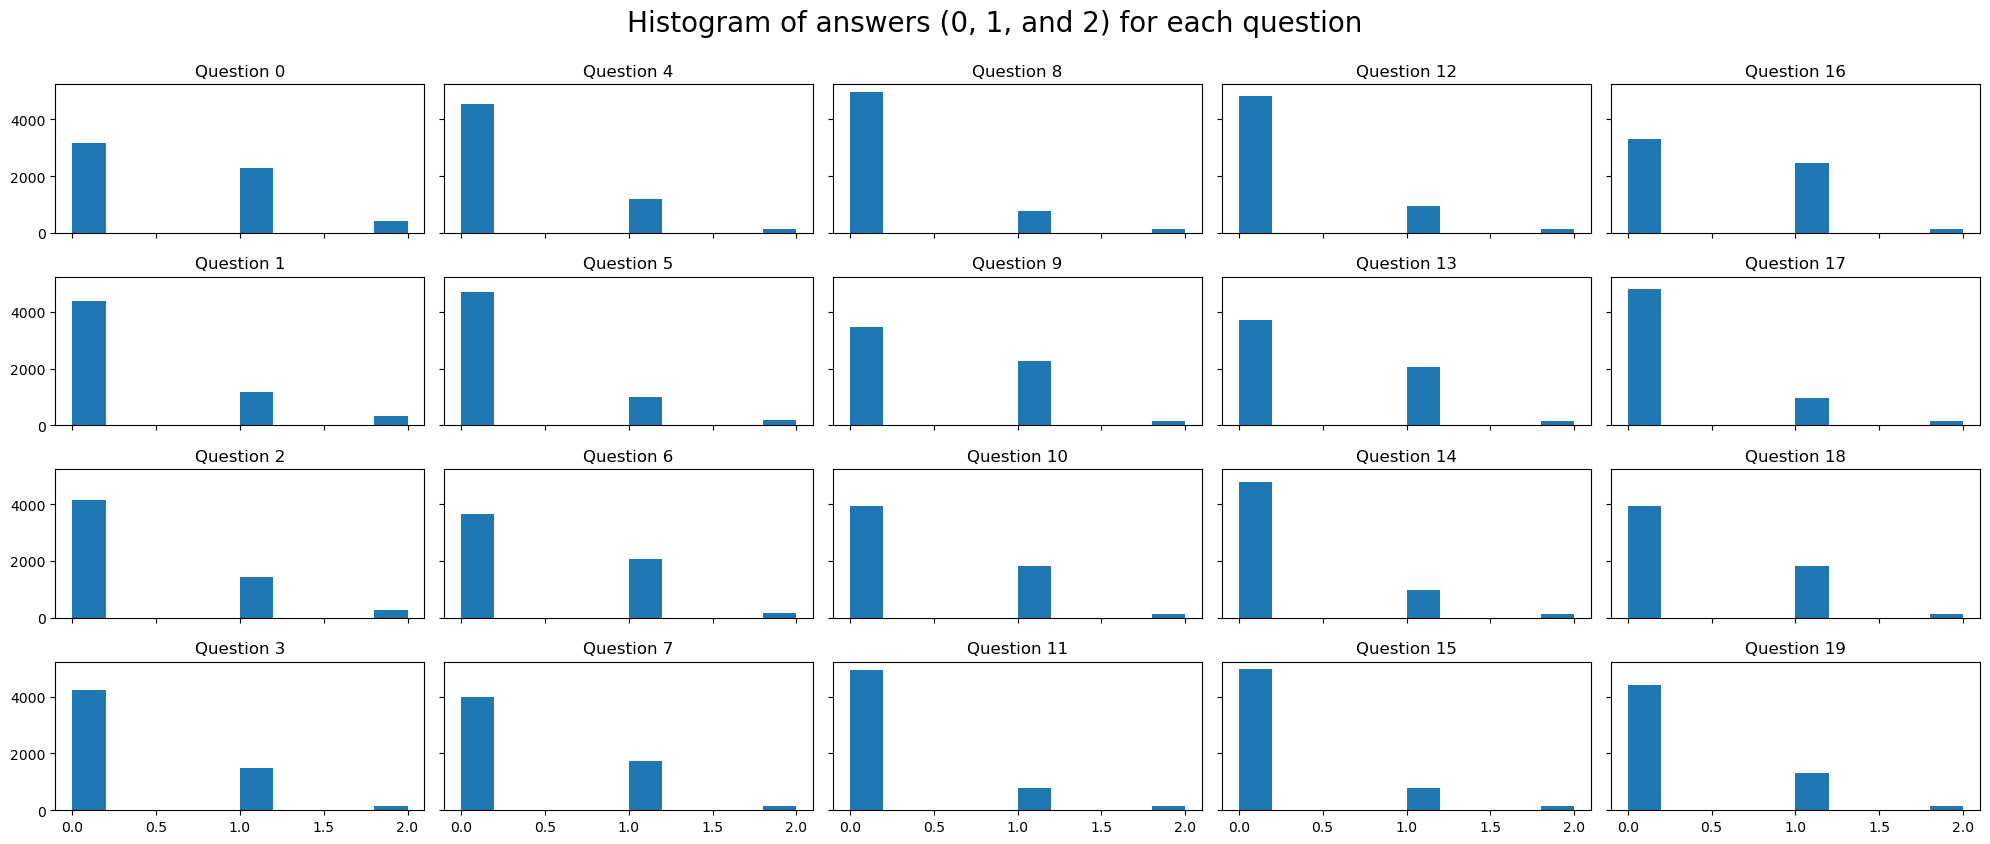

In [15]:
def plot(df):
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        sbplt = ax[i%4, math.floor(i/4)]
        sbplt.hist(df[f'q_{i}'])
        sbplt.set_title(f'Question {i}')

    fig.tight_layout()
    fig.suptitle('Histogram of answers (0, 1, and 2) for each question', y=1.05, fontsize=20)
    plt.show()

plot(gpt_answers)

Let's see what this plot looks like if we only consider positive and negative answers (replacing the '2's by missing values)

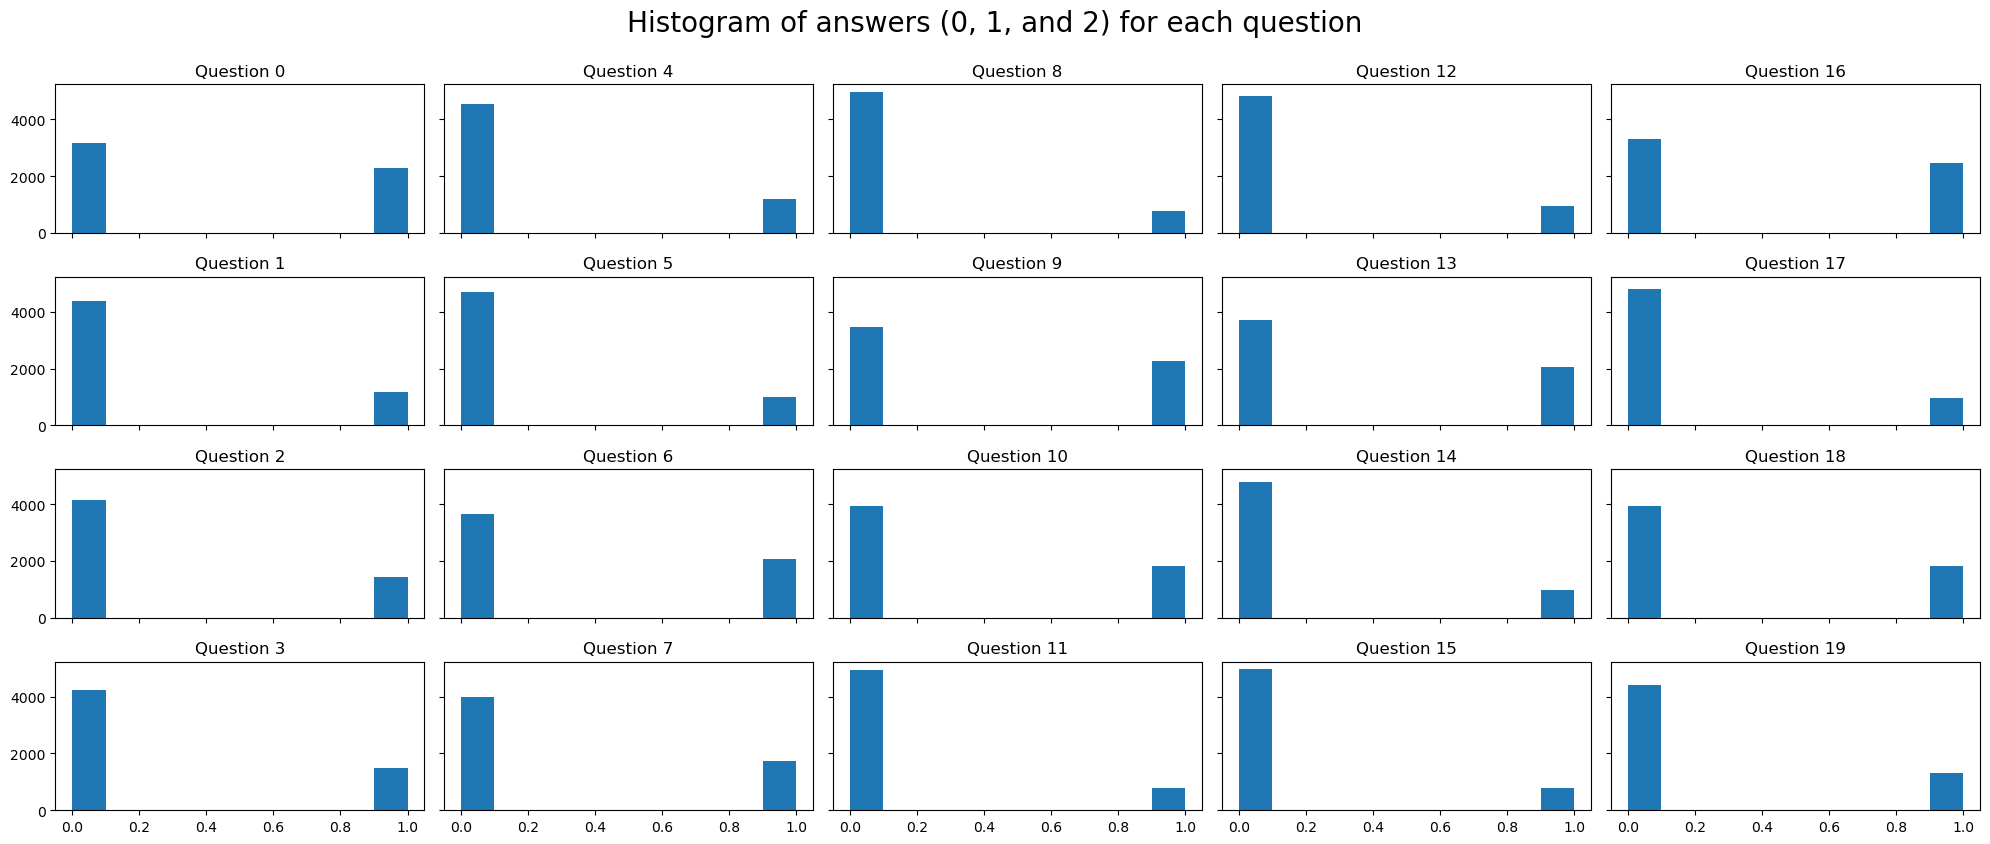

In [16]:
gpt_answers_nan = gpt_answers.replace(2, np.NaN, inplace=False)
plot(gpt_answers_nan)

This is somewhat hard to compare, let's plot pie charts instead to facilitate comparison of percentages.

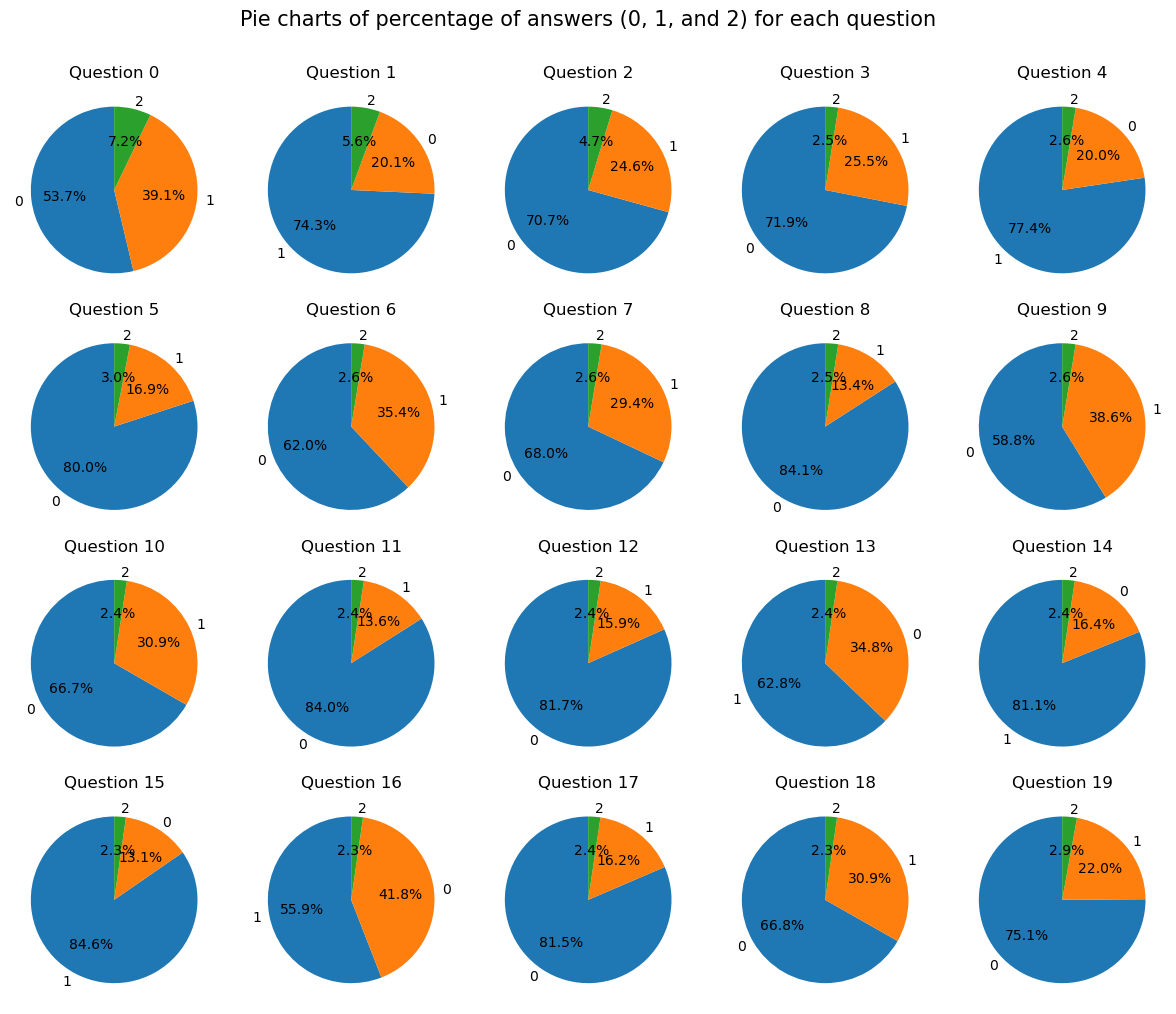

In [17]:
def plot_pie_charts(df):
    fig, ax = plt.subplots(nrows = 4, ncols = 5, figsize = (12,10))

    for r in range(4):
        for c in range(5):
            ax[r,c].pie(df[f'q_{r*5+c}'].value_counts(),
                        labels = df[f'q_{r*5+c}'].dropna().unique(),
                        autopct=lambda p: '{:.1f}%'.format(p),
                        startangle=90, shadow=False)
            ax[r,c].set_title(f'Question {r*5+c}')
    
    fig.suptitle('Pie charts of percentage of answers (0, 1, and 2) for each question', y=1.01, fontsize=15)
    fig.tight_layout()
            
plot_pie_charts(gpt_answers)

and again without the unknown answers ('2's).

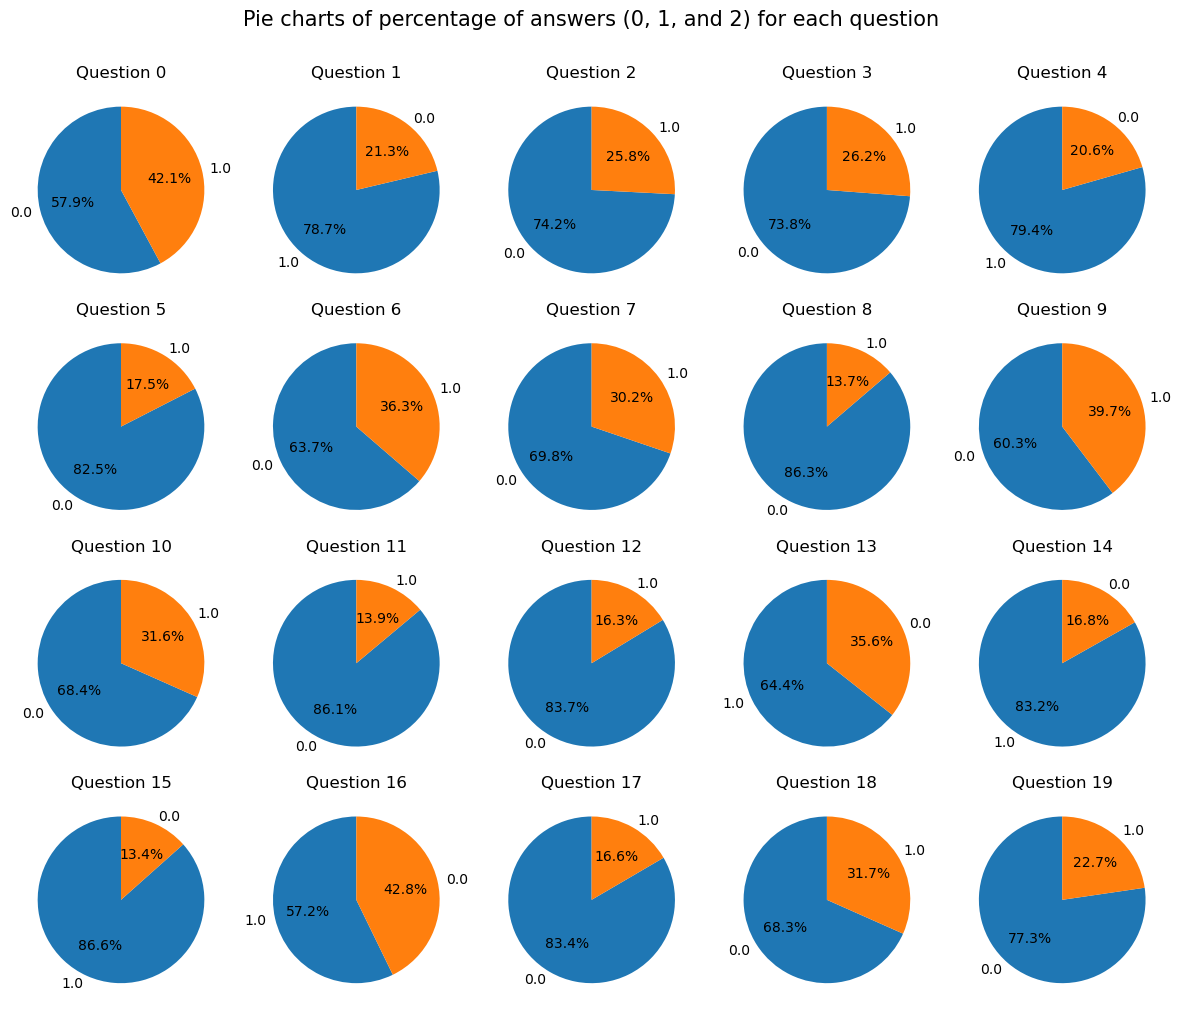

In [18]:
plot_pie_charts(gpt_answers_nan)

Now let's remove the entries with only twos, as they do not give any information. Likewise, we remove all 0's. This is because sometimes,movies are classified as romance even though they aren't. For example, some of the "Harry Potter" movies are classified as "Romance", but clearly, that is not the kind of movie we're interested in. Indeed, the answer to all questions we asked is "no". We also remove all entried containing just 0's and 2's, because if the answer is either no or unknown, it is probably not a romance movie anyway. In short, we keep all strings that have at least one "1".

We use `binary_answers` for this (not the encoding done previously with one column per question).

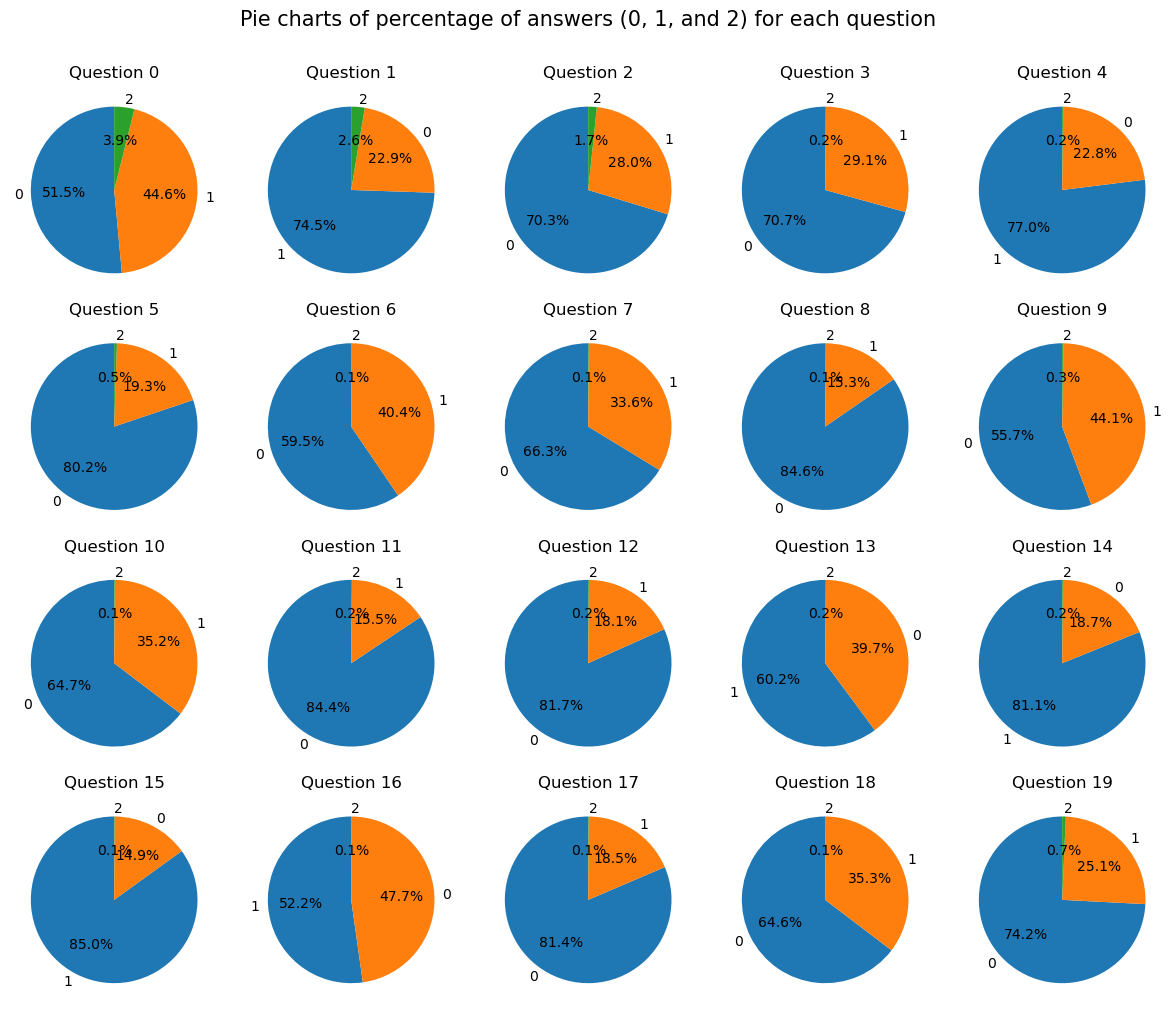

In [19]:
relevant_answers = gpt_answers[gpt_answers['binary_answers'].str.contains('1')].copy()
plot_pie_charts(relevant_answers)

In [20]:
len(relevant_answers)

5159

In [21]:
len(relevant_answers)

5159

If we ignore the "all unknown" or "probably not romance" movies, we are left with 3 questions out of the 20 questions with more that 1% of answers unknown over all movies (roughly 5200 movies). Let's have a look at the questions the chat gpt API seems to have more trouble answering:

In [22]:
for i, question in questions.items():
    twos = relevant_answers[relevant_answers[f'q_{i}']==2]
    if len(twos)/len(relevant_answers)>=1/100:
        print(i, question)

0 - Is there a wedding stopped at the altar trope ?
1 - Is there a best friend to lovers trope ?
2 - Is there a enemies to lovers trope ?


Let's try to understand how and if this evolves over time.

In [23]:
col_to_keep = ['movie_id', 'movie_release', 'binary_answers']
for i in range(len(questions)):
    col_to_keep.append(f'q_{i}')
    
#right merge because we only care about the relevant answers
gpt_year = romance_with_binary.merge(relevant_answers, on=['movie_id', 'binary_answers'], how='right')[col_to_keep]
gpt_year.replace(2, np.NaN, inplace=True)

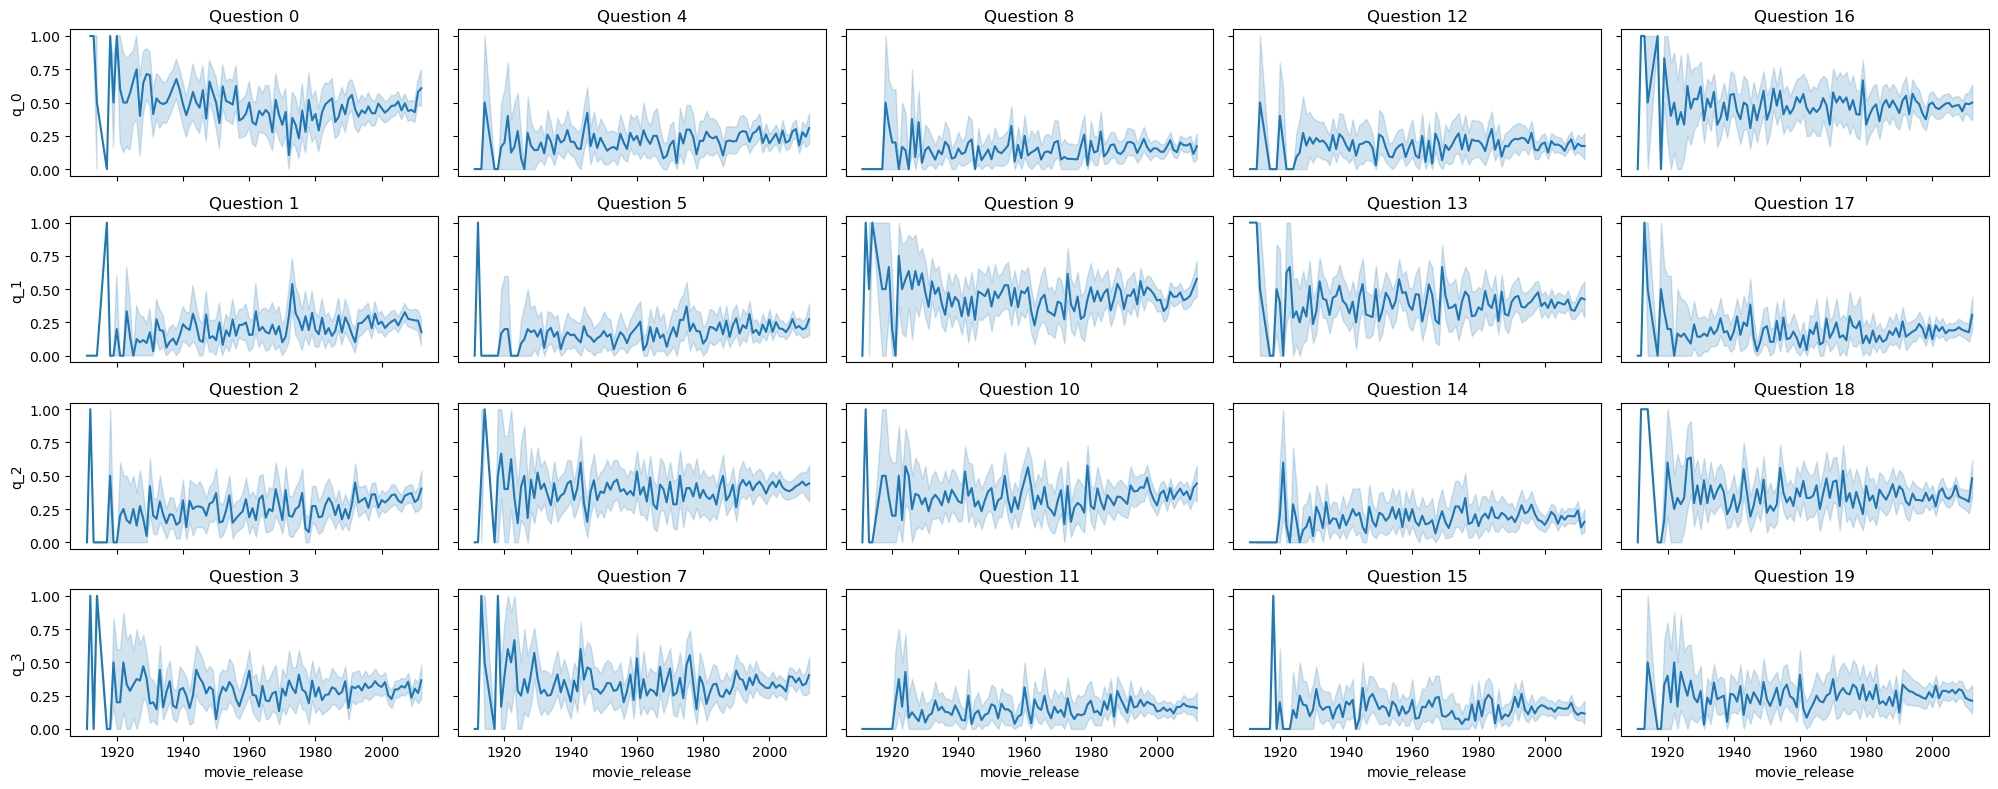

In [24]:
def plot_answer_by_year(df, sharey): 
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = sharey, sharex = True)

    for i in range(20):
        ax[i%4, math.floor(i/4)].set_title(f'Question {i}')
        sns.lineplot(df, x='movie_release', y=f'q_{i}', ax=ax[i%4, math.floor(i/4)])

    fig.tight_layout()
    plt.show()
    
plot_answer_by_year(gpt_year, sharey=True)

There seems to be some variance in the earlier years, until roughyl 1920. This makes sense: there were fewer movies back then. If we only consider the movies after 1920, we see the following:

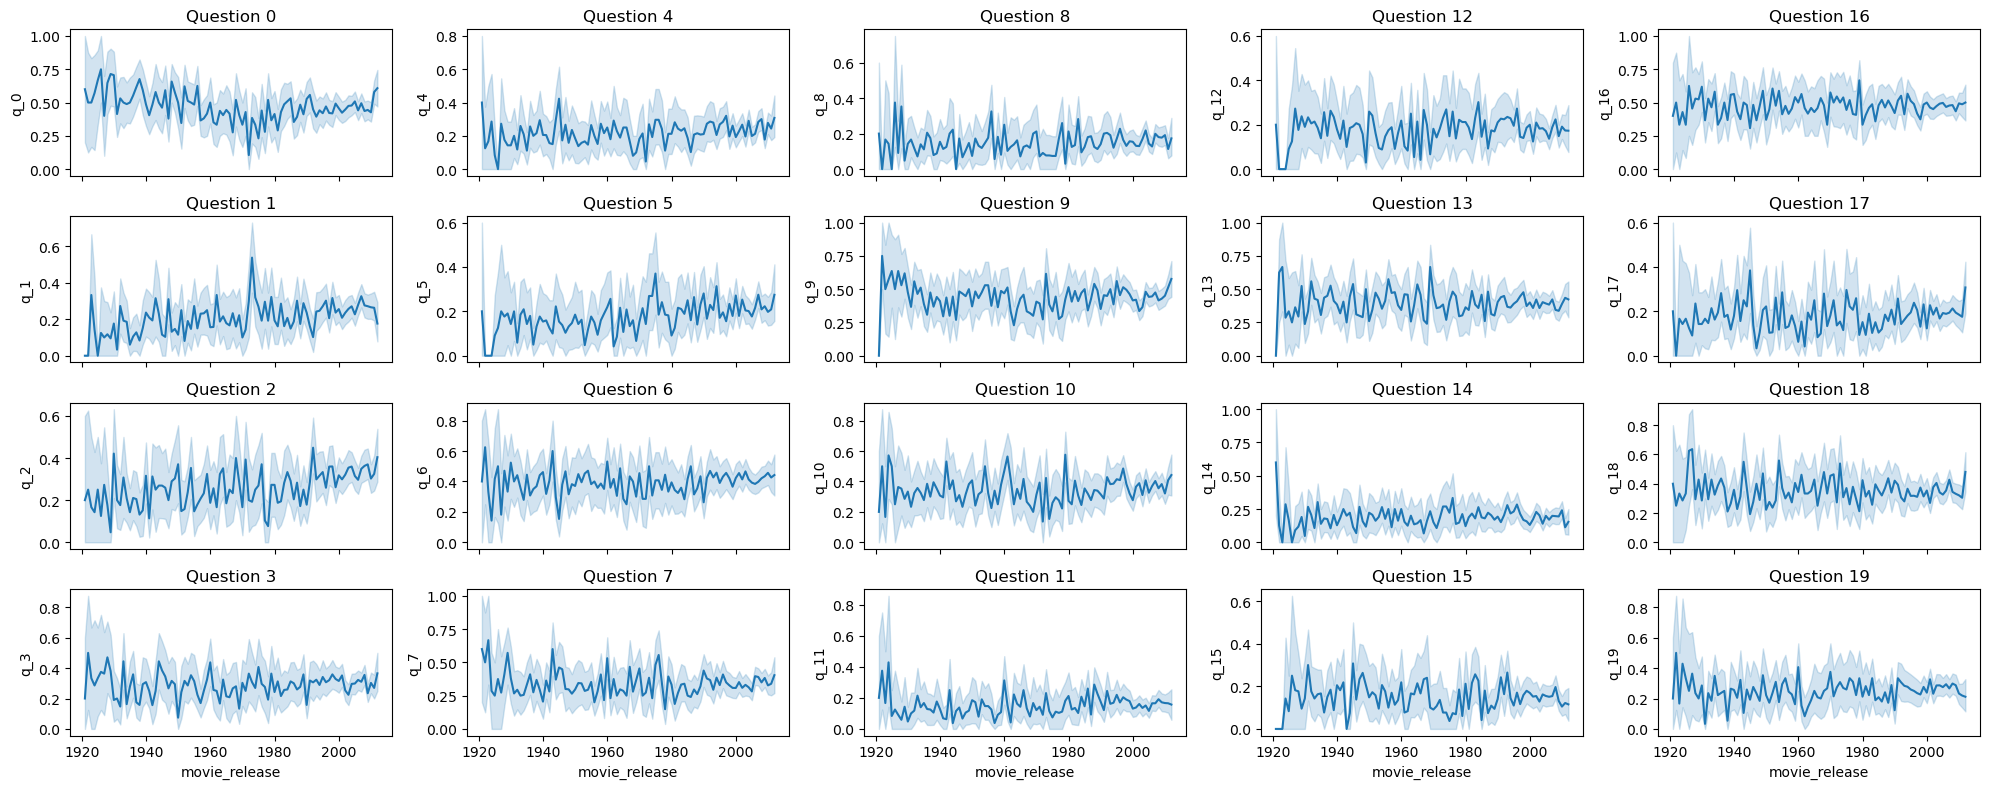

In [25]:
plot_answer_by_year(gpt_year[gpt_year['movie_release']>1920], sharey=False)

It seems that the answers to the questions are, on average, the same over the years. There is no visible trend of evolution over the past century with respect to the answer of these questions.

We had a look at the evolution over time, but what about specific months? For example, it makes sense that movies in December or February are more likely to have "yes" as an answer to the question "Is the movie linked to a special holliday (christmas, valentine's day...)?". Let's see if this intuition is correct. Recall that we removed the months in the beginning of the preprocessing, se we need to take the original movies dataframe again, merge it with our current dataframe and extract the months when possible. Note that the formats are `yyyy`, `yyyy-mm` or `yyyy-mm-dd` (or NaN).

In [26]:
movies_full = pd.read_csv('./Data/MovieSummaries/movie.metadata.tsv', delimiter='\t',
                             names = ['movie_id', 'Freebase movie ID', 'Movie name',
                                      'movie_date', 'Movie box office revenue', 'Movie runtime',
                                      'Movie languages', 'Movie countries', 'Movie genres'])
movies = movies_full[['movie_id', 'movie_date']].copy()
movies.sample(5)

,movie_id,movie_date
6889,22644761,1989
53588,19874993,1981-05-11
28847,9044882,2006
955,934809,1959
78973,18777188,1996


In [27]:
def extract_year_month_day(date):
    nan = -1
    if type(date) != str:
        return nan, nan, nan
    date = date.split('-')
    if len(date) == 1:
        year = int(date[0])
        month = nan
        day = nan
    elif len(date)==2:
        year = int(date[0])
        month = int(date[1])
        day = nan
    elif len(date)==3:
        year = int(date[0])
        month = int(date[1])
        day = int(date[2])
    return year, month, day

In [28]:
movies['y_m_d'] = movies['movie_date'].apply(lambda date : extract_year_month_day(date))

In [29]:
movies['year'] = movies['y_m_d'].apply(lambda tuple_ : tuple_[0])
movies['month'] = movies['y_m_d'].apply(lambda tuple_ : tuple_[1])
movies['day'] = movies['y_m_d'].apply(lambda tuple_ : tuple_[2])
movies.replace(-1, np.NaN, inplace=True)
movies

,movie_id,movie_date,y_m_d,year,month,day
0,975900,2001-08-24,"(2001, 8, 24)",2001.0,8.0,24.0
1,3196793,2000-02-16,"(2000, 2, 16)",2000.0,2.0,16.0
2,28463795,1988,"(1988, -1, -1)",1988.0,NaN,NaN
3,9363483,1987,"(1987, -1, -1)",1987.0,NaN,NaN
4,261236,1983,"(1983, -1, -1)",1983.0,NaN,NaN
...,...,...,...,...,...,...
81736,35228177,2011-03-19,"(2011, 3, 19)",2011.0,3.0,19.0
81737,34980460,2011-01-21,"(2011, 1, 21)",2011.0,1.0,21.0
81738,9971909,1972-09-22,"(1972, 9, 22)",1972.0,9.0,22.0
81739,913762,1992-05-21,"(1992, 5, 21)",1992.0,5.0,21.0


In [30]:
relevant_answers.head(3)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
0,6631279,01001000000001111000,0,1,0,0,1,0,0,0,...,0,0,0,1,1,1,1,0,0,0
1,21926710,00000001000001000100,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,26067101,01000000001000001000,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [31]:
answer_with_months = relevant_answers.merge(movies, on='movie_id', how='left')
answer_with_months.sample(3)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,q_15,q_16,q_17,q_18,q_19,movie_date,y_m_d,year,month,day
3195,11464872,11000011100110100010,1,1,0,0,0,0,1,1,...,0,0,0,1,0,2002-10-16,"(2002, 10, 16)",2002.0,10.0,16.0
3149,1126572,10000010000000000100,1,0,0,0,0,0,1,0,...,0,0,1,0,0,2003-03-27,"(2003, 3, 27)",2003.0,3.0,27.0
74,508985,00100010111001001002,0,0,1,0,0,0,1,0,...,0,1,0,0,2,1997-05-11,"(1997, 5, 11)",1997.0,5.0,11.0


In [32]:
questions_indices = [f'q_{i}' for i in range(len(questions))]

In [33]:
average_answer_by_month = answer_with_months.groupby('month', as_index=False)[questions_indices].mean()
average_answer_by_month.sample(3)

,month,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,q_8,...,q_10,q_11,q_12,q_13,q_14,q_15,q_16,q_17,q_18,q_19
6,7.0,0.431718,0.290749,0.290749,0.281938,0.242291,0.154185,0.409692,0.312775,0.189427,...,0.330396,0.162996,0.180617,0.392070,0.180617,0.176211,0.431718,0.162996,0.343612,0.255507
2,3.0,0.544444,0.259259,0.325926,0.337037,0.200000,0.218519,0.385185,0.340741,0.155556,...,0.333333,0.140741,0.185185,0.359259,0.188889,0.129630,0.459259,0.200000,0.359259,0.270370
0,1.0,0.496124,0.294574,0.329457,0.267442,0.209302,0.217054,0.410853,0.364341,0.174419,...,0.375969,0.155039,0.166667,0.406977,0.205426,0.166667,0.476744,0.209302,0.360465,0.298450


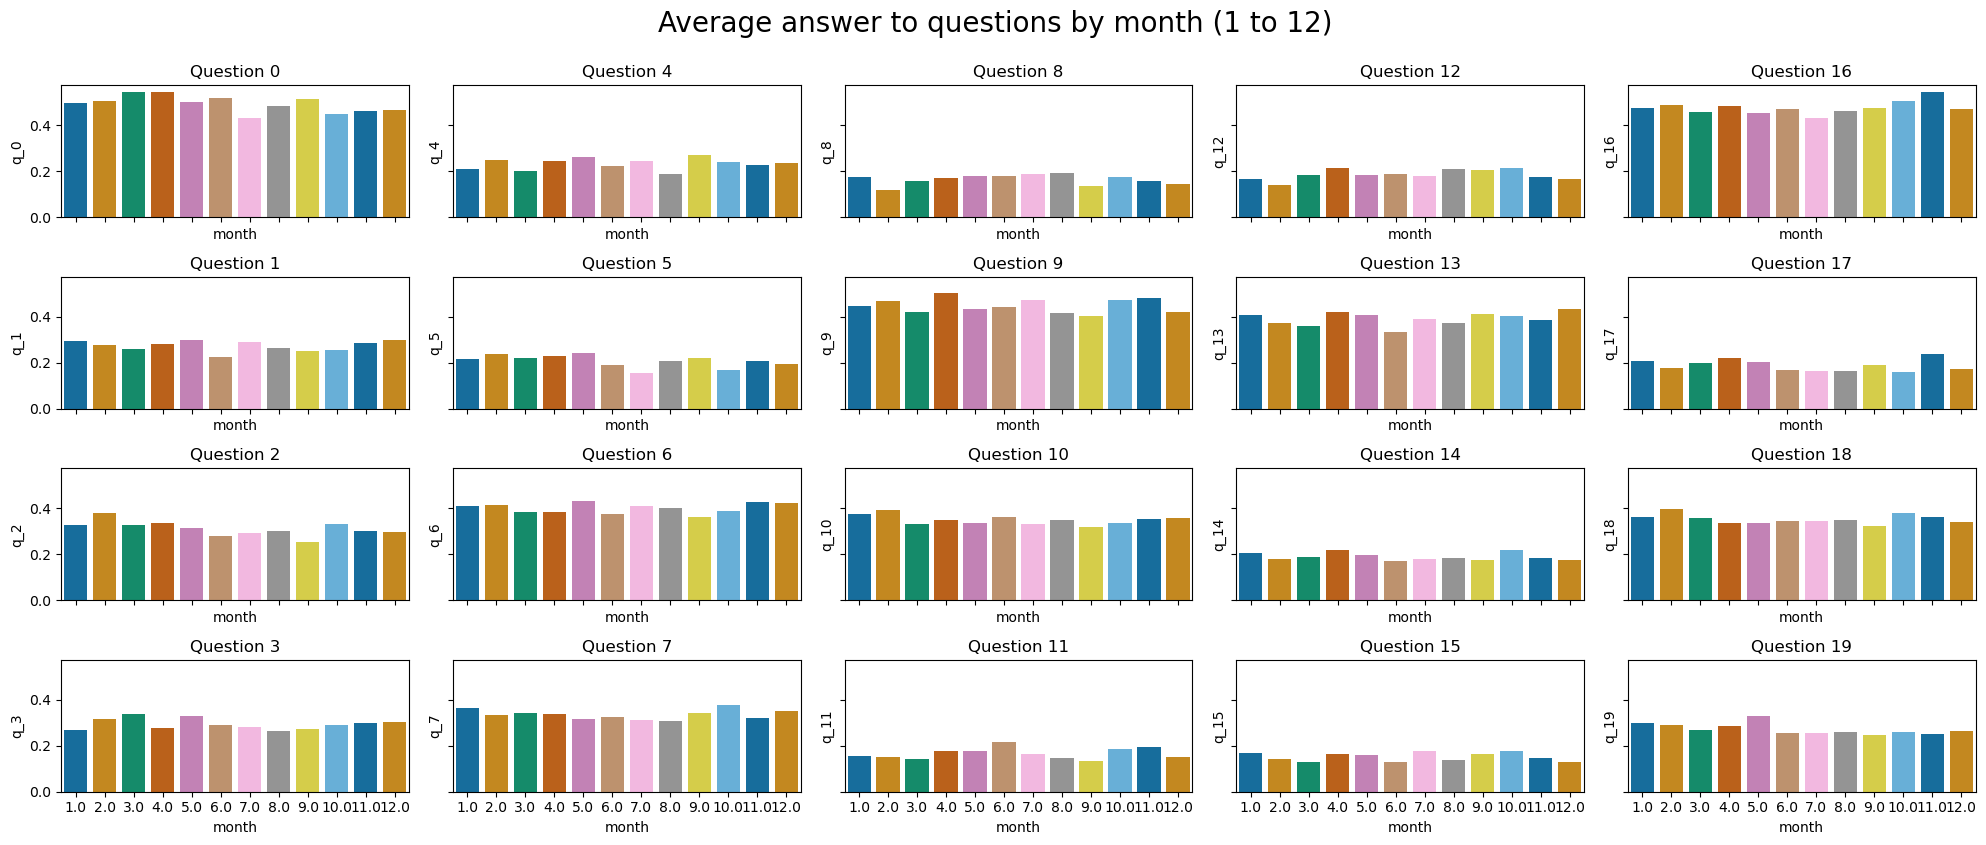

In [34]:
def plot_mean_answer_by_month(df): 
    fig, ax = plt.subplots(4, 5, figsize= (20,8), sharey = True, sharex = True)

    for i in range(20):
        ax[i%4, math.floor(i/4)].set_title(f'Question {i}')
        colors = sns.color_palette("colorblind")
        sns.barplot(data=df, x='month', y=f'q_{i}', ax=ax[i%4, math.floor(i/4)], palette=colors)

    fig.tight_layout()
    fig.suptitle('Average answer to questions by month (1 to 12)', y=1.05, fontsize=20)
    plt.show()
    
plot_mean_answer_by_month(average_answer_by_month)

There does not seem to be a change in answer to the questions based on which month the movie comes out. We supposed that, for example, movies with the answer "yes" to question 18 might more often come out in november/december, but this does not seem to be the case. To find the validity, we should check how many movies we have that have information about the months at all. Perhaps movies that both have a yes to this question and come out during the holidays are better liked however. This will (I hope) be checked later on (todo?). Also: add error bars?

In [35]:
x_df = relevant_answers[questions_indices].cov()
x = x_df.to_numpy()

for i in range(x.shape[0]):
    for j in range(i+1, x.shape[1]):
        if np.abs(x[i, j])>0.1:
            print(f'non negligeable correlation for questions {i} and {j}: {x[i, j]:.4f}')

Note that out of the 5700 movies we have with relevant answers, about 4000 have data about the month. The others don't have any information about the month in which the movies came out. Let's plot how many movies have come out by month to see if these 4000 movies are evenly distributed.

In [36]:
movies_with_month = answer_with_months[answer_with_months.month.isna()==0]

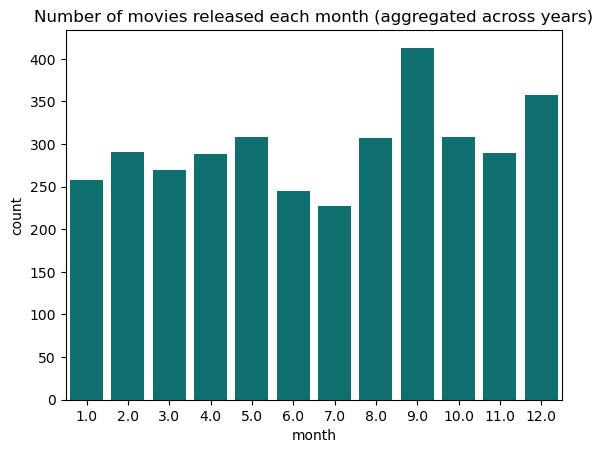

In [37]:
plt.title('Number of movies released each month (aggregated across years)')
sns.countplot(movies_with_month, x="month", color='teal')
plt.show()

Now, let's try to have a look at the ratings and whether:

In [38]:
movies_rating = pd.read_csv('./Data/Preprocessed/movie.metadata.augmented.tsv', delimiter='\t')
movies_rating['genres'] = movies_rating['genres'].apply(lambda genre : ast.literal_eval(genre))
movies_rating['languages'] = movies_rating['languages'].apply(lambda language : ast.literal_eval(language))
movies_rating['countries'] = movies_rating['countries'].apply(lambda countries : ast.literal_eval(countries))

In [39]:
ratings = answer_with_months.merge(movies_rating, on='movie_id', how='left')
ratings.sample(4)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes
2522,21532286,10000011000010100001,1,0,0,0,0,0,1,1,...,Beder Meye Josna,NaN,120.0,{'/m/01c7y': 'Bengali Language'},"{'/m/0162b': 'Bangladesh', '/m/03rk0': 'India'}",1991.0,"[Drama, Romance]",tt0197278,7.0,379.0
1503,30408196,00010010010010000100,0,0,0,1,0,0,1,0,...,Heartbeats,588383.0,97.0,"{'/m/064_8sq': 'French Language', '/m/02h40lc'...",{'/m/0d060g': 'Canada'},2010.0,"[Romance, Black Comedy, Comedy, LGBT, World Ci...",tt1600524,7.0,30006.0
4448,16489478,10110011011001001002,1,0,1,1,0,0,1,1,...,Kovil,NaN,147.0,{'/m/07c9s': 'Tamil Language'},{'/m/03rk0': 'India'},2003.0,"[Drama, World Cinema, Romance]",tt1483773,6.0,905.0
3376,10556466,11011111111111111000,1,1,0,1,1,1,1,1,...,Intruso,NaN,86.0,{'/m/06nm1': 'Spanish Language'},{'/m/06mkj': 'Spain'},1993.0,"[Drama, World Cinema, Romance]",tt0107224,5.7,355.0


Let's try to see if movies that came out around the holidays and were answered "yes" about question 17 are rated differently.

- Is the ending sad ?


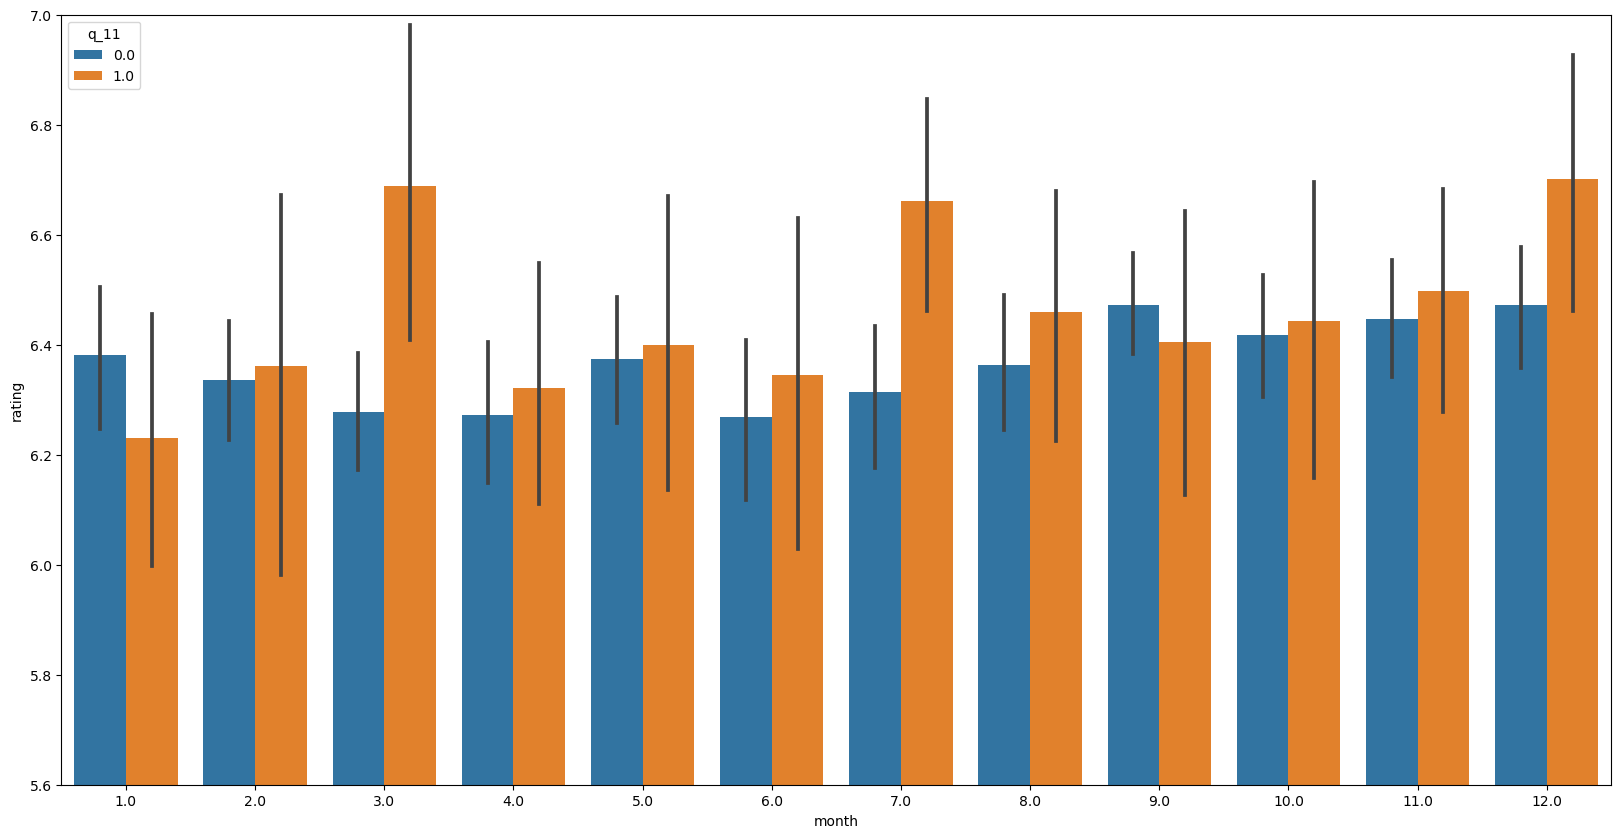

In [40]:
question_number = 11 #4 #5 #6 #8 #10 #11 #15
print(questions[question_number])

df_cleaned = ratings.dropna(subset=[f'q_{question_number}', 'month']).copy()
df_cleaned[questions_indices] = df_cleaned[questions_indices].replace(2, np.NaN)
dft = df_cleaned.copy()

plt.figure(figsize=(20, 10))
sns.barplot(dft, x='month',  y='rating', hue=f'q_{question_number}')

plt.ylim(5.6, 7)
plt.show()

For further use, we want to save the relevant answer merged with out preprocessed movies information (including the ratings). Note that we merge left because our focus here are the relevant answers.

In [41]:
to_save = relevant_answers.merge(movies_rating, on='movie_id', how='left')
to_save.sample(2)

,movie_id,binary_answers,q_0,q_1,q_2,q_3,q_4,q_5,q_6,q_7,...,movie_name,revenue,runtime,languages,countries,movie_release,genres,imdb_id,rating,nb_votes
4948,7645983,20201000000000101000,2,0,2,0,1,0,0,0,...,Saigon Eclipse,NaN,90.0,"{'/m/07zrf': 'Vietnamese Language', '/m/02h40l...",{'/m/01crd5': 'Vietnam'},2007.0,"[Thriller, Drama, World Cinema, Romance]",tt0485146,5.6,60.0
609,1052246,00000100010010000010,0,0,0,0,0,1,0,0,...,Topsy Turvy,6201757.0,160.0,"{'/m/064_8sq': 'French Language', '/m/03_9r': ...",{'/m/07ssc': 'United Kingdom'},1999.0,"[Romance, Parody, Comedy, History, Indie, Biop...",tt0151568,7.4,13275.0


In [42]:
to_save.to_csv('./Data/Preprocessed/gpt_answers.tsv', sep="\t", index=False) 

ToDo:
- are movies about holidays on holidays better liked? DONE
- create dictionary "q_xx" to question DONE
- **save stuff merged with ratings** DONE
- choisir 9-10 questions, match sur les réponses, treatment vs control = une des questions (eg hw 2: rebuttal <-> question n, exact matching on questions i, j, k, l, m, acceptance <-> rating). Note: to do after feature selection to know which questions to match on.